In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from corr import Analyse_CORR as CORR

OK


d:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [7]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hk=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol']
df1=hk.get_main_contract_bars('HHI', _fields, begin)

print(dt.datetime.now()-dt1)

0:00:41.988402


In [154]:
# df1.to_pickle("pkl/hsi.pkl")
# df1.to_pickle("pkl/hhi.pkl")
# df1=pd.read_pickle("pkl/hsi.pkl")
df1=pd.read_pickle("pkl/hhi.pkl")
df1['ma60']=tb.MA(df1.close.values,timeperiod=60)
df1['ma30']=tb.MA(df1.close.values,timeperiod=30)
# df1.head(10)
df1.shape
# df1.head()

(1221117, 8)

In [155]:
# df2.datetime.apply(lambda x:x.time())
time1=dt.time(9,15,0)
time2=dt.time(16,30,0)
newDF=df1[(df1.datetime.dt.time>=time1)&(df1.datetime.dt.time<=time2)]
newDF.head(5)
# new1=newDF.reset_index(drop=True)

datetime     code     open     high      low  \
datetime                                                                      
2011-01-03 09:45:00 2011-01-03 09:45:00  HHI1101  12753.0  12788.0  12736.0   
2011-01-03 09:46:00 2011-01-03 09:46:00  HHI1101  12750.0  12754.0  12727.0   
2011-01-03 09:47:00 2011-01-03 09:47:00  HHI1101  12736.0  12736.0  12727.0   
2011-01-03 09:48:00 2011-01-03 09:48:00  HHI1101  12733.0  12733.0  12727.0   
2011-01-03 09:49:00 2011-01-03 09:49:00  HHI1101  12731.0  12733.0  12728.0   

                       close  ma60  ma30  
datetime                                  
2011-01-03 09:45:00  12753.0   NaN   NaN  
2011-01-03 09:46:00  12737.0   NaN   NaN  
2011-01-03 09:47:00  12733.0   NaN   NaN  
2011-01-03 09:48:00  12731.0   NaN   NaN  
2011-01-03 09:49:00  12729.0   NaN   NaN

In [157]:
def Calc(date1,Stop_Type=1):
    #Stop_type 0不止损，1固定止损(收盘价)，2估定止损（高低价），3.称动止损(收盘价)，4移动止损(高低价)
    
#     date1='2014-01-02'
    D1=newDF[str(date1)]
    O=D1.iloc[0]['close']
    C=D1.iloc[-1]['close']
    H=D1['close'].max()
    L=D1['close'].min()
    Hi=D1['high'].idxmax().time()
    Li=D1['low'].idxmin().time()
    res={}
    res['Date']=D1.iloc[0]['datetime'] 
    res['State']=0
    res['Open']=O
    res['High']=H
    res['Low']=L
    res['Close']=C
    res['Hi']=Hi
    res['Li']=Li
    
    H1=D1[:60]['close'].max()
    L1=D1[:60]['close'].min()
    res['High1']=H1
    res['Low1']=L1
    res['W1']=H1-L1
    res['Close1']=D1.iloc[59]['close']
    res['DiffH']=H1-res['Close1']
    res['DiffL']=res['Close1']-L1
    res['H1i']=D1[:60]['close'].idxmax().time()
    res['L1i']=D1[:60]['close'].idxmin().time()
    res['PreState']=1 if res['H1i']>res['L1i'] else 0
    if res['W1']>300 and res['PreState']==1:
        return res

#state[1多赚，3多亏，5多止损赚，7止损亏， 2空赚，4空亏，6空止损赚，8止损亏]
#     print(H1,L1,H1-L1)
    H2=0      #成交后的最高价
    L2=50000     #成交后的最低价
    Stop=(H1-L1)*0.5
    if Stop<40:
        Stop=40
    if Stop>220:
        Stop=220
        
    StopGo=True
    res['Stop']=Stop
    MoveStop=0
    for row in D1[60:].iterrows():
        close=row[1]['close']
        if res['State']==1 or res['State']==2:
            H2=close if close>H2 else H2
            L2=close if close<L2 else L2
            
            if Stop_Type==2 or Stop_Type==4:
               #高低触发止损
                cont1=res['State']==1 and row[1]['low']<MoveStop and StopGo
                cont2=res['State']==2 and row[1]['high']>MoveStop and StopGo
            elif Stop_Type==1 or Stop_Type==3:
                #移动止损
                cont1=res['State']==1 and close<MoveStop and StopGo
                cont2=res['State']==2 and close>MoveStop and StopGo
            elif Stop_Type==0:
                cont1=False
                cont2=False
            
#             #移动止损
            if res['State']==1 and (close-Stop)>MoveStop and (Stop_Type==3 or Stop_Type==4):
                MoveStop=close-Stop
            elif res['State']==2 and (close+Stop)<MoveStop and (Stop_Type==3 or Stop_Type==4):
                MoveStop=close+Stop
            
            if cont1 :
                res['StopPrice']=close
                StopGo=False
                if Stop_Type==1 or Stop_Type==3:
                    res['Diff_S']=close-res['Price']-1
                    res['State']=7
                else:
                    res['Diff_S']=MoveStop-res['Price']-2
                    res['State']=7 if res['Diff_S']>0 else 8

            elif cont2:
                res['StopPrice']=close
                StopGo=False
                if Stop_Type==1 or Stop_Type==3:
                    res['Diff_S']=res['Price']-close-1
                    res['State']=9
                else:
                    res['Diff_S']=res['Price']-MoveStop-2
                    res['State']=9 if res['Diff_S']>0 else 10
        elif (close>H1 or close<L1) and res['State']==0:
            res['Price']=close
            res['Ref']=row[0]
            if close>H1:
                res['Diff']=res['Close']-res['Price']-1
                res['State']=1
                MoveStop=close-Stop
            else:
                res['Diff']=res['Price']-res['Close']-1
                res['State']=2
                MoveStop=close+Stop
            res['Diff_S']=res['Diff']
                
    if StopGo and res['State']==1:
        res['State']=3 if res['Diff']>0 else 5
    elif StopGo and res['State']==2:
        res['State']=4 if res['Diff']>0 else 6
            
            
    res['High2']=H2
    res['Low2']=L2
    return res

def GetROI(F1):
    Res={}
    Res['ALL_Profit'],Res['All_CNT']=F1['Diff'].agg(['sum','count'])
    Res['Win'],Res['Win_CNT']=F1[F1.Diff>0]['Diff'].agg(['sum','count'])
    Res['Lose'],Res['Lose_CNT']=F1[F1.Diff<0]['Diff'].agg(['sum','count'])
    Res['Win_Mean']=Res['Win']/Res['Win_CNT']
    Res['Lose_Mean']=Res['Lose']/Res['Lose_CNT']
    Res['All_Mean']=Res['ALL_Profit']/Res['All_CNT']
    Res['Win/Lose']=Res['Win_Mean']/-Res['Lose_Mean']
    Res['Win%']=Res['Win_CNT']*100/(Res['Lose_CNT']+Res['Win_CNT'])
    Res['ROI']=Res['Win/Lose']*Res['Win%']-50.0
    return Res

print("OK")

OK


In [156]:
#修改重写 20190508 13:21
def CalcHL(date,PreClose=0,Stop_Type=1,Begin=0):
    #Stop_type 0不止损，1固定止损(收盘价)，2固定止损（高低价），3.称动止损(收盘价)，4移动止损(高低价)
    # date1='2014-01-02'
    
    #初始化
    Para={}
    D1=newDF[str(date)]
    Para['Len']=len(D1)
    res={}
    res['PreClose']=PreClose
    res['Date']=date
    res['State']=0
    res['Open']=D1.iloc[0]['close']
    res['High']=D1['close'].max()
    res['Low']=D1['close'].min()
    res['Close']=D1.iloc[-1]['close']
    res['OpenH']=res['Open']-res['PreClose'] if PreClose>0 else 0
    #Trend[1顺势多，2顺势空，3逆势多，4逆势空]
    res['Trend']=0
    
    
    Para['Cost']=2     #设置滑点
    Para['Begin']=Begin
    Para['End']=Begin+60
    PreDF=D1[Para['Begin']:Para['End']]
    IndexList=PreDF.index.tolist()
    H_idx=PreDF['close'].idxmax()
    L_idx=PreDF['close'].idxmin()
    res['H1_idx']=IndexList.index(H_idx)
    res['L1_idx']=IndexList.index(L_idx)
    res['High1']=PreDF['close'].max()
    res['Low1']=PreDF['close'].min()
    res['W1']=res['High1']-res['Low1']
    if Para['End']-1>(Para['Len']-60):
        return res
    res['Close1']=D1.iloc[Para['End']-1]['close']
    

    #state[1:多赚，3多亏，5止损赚，7止损亏，2空，4空赚，6空亏，8空止损]

    Para['H2']=0         #成交后的最高价
    Para['L2']=50000     #成交后的最低价
    Para['Stop']=res['W1']*0.5
    if Para['Stop']<40:
        Para['Stop']=40
    if Para['Stop']>220:
        Para['Stop']=220
    res['Stop']=Para['Stop']
    
    Para['StopGo']=False
    Para['MoveStop']=0
    
    #数据循环
    Para['Index']=0
    Para['Trade_State']=0  #[0:初始化， 1:刚开多单， 2：刚开空单 ]
    for i,row in D1[Para['End']:].iterrows():
        close=row['close']
        
        #开仓
        if row['close']>res['High1'] and Para['Trade_State']==0:
            Para['Trade_State']=1
            Para['StopGo']=True
            res['Trend']=1 if res['H1_idx']>res['L1_idx'] else 3
            res['Price']=row['close']
            res['Ref']=Para['Index']
            res['Diff']=res['Close']-res['Price']-Para['Cost']
            res['State']=9 if res['Diff']>0 else 11
            Para['MoveStop']=res['Price']-Para['Stop']
            Para['Index']+=1
            continue
        elif row['close']<res['Low1'] and Para['Trade_State']==0:
            Para['Trade_State']=2
            Para['StopGo']=True
            res['Trend']=2 if res['H1_idx']<res['L1_idx'] else 4
            res['Price']=row['close']
            res['Ref']=Para['Index']
            res['Diff']=res['Price']-res['Close']-Para['Cost']
            res['State']=10 if res['Diff']>0 else 12
            Para['MoveStop']=res['Price']+Para['Stop']
            Para['Index']+=1
            continue

              
        if Para['Trade_State'] in [1,2] and Para['StopGo']:
            Para['H2']=close if close>Para['H2'] else Para['H2']
            Para['L2']=close if close<Para['L2'] else Para['L2']
              
            #移动止损
            if Para['Trade_State']==1 and (close-Para['Stop'])>Para['MoveStop'] and Stop_Type in[3,4]:
                Para['MoveStop']=close-Para['Stop']
            elif Para['Trade_State']==2 and (close+Para['Stop'])<Para['MoveStop'] and Stop_Type in[3,4]:
                Para['MoveStop']=close+Para['Stop']

            #收盘价止损
            if Para['Trade_State']==1 and close<Para['MoveStop'] and Para['StopGo'] and Stop_Type in[1,3]:
                Para['StopGo']=False
                res['StopPrice']=close
                res['Diff']=Para['MoveStop']-res['Price']-Para['Cost']
                if Stop_Type==1:
                    res['State']=1 if res['Diff']>0 else 3
                else:
                    res['State']=5 if res['Diff']>0 else 7
                break
            elif Para['Trade_State']==2 and close>Para['MoveStop'] and Para['StopGo'] and Stop_Type in[1,3]:
                Para['StopGo']=False
                res['StopPrice']=close
                res['Diff']=res['Price']-Para['MoveStop']-Para['Cost']
                if Stop_Type==1:
                    res['State']=2 if res['Diff']>0 else 4
                else:
                    res['State']=6 if res['Diff']>0 else 8
                break

            #高低触发止损
            elif Para['Trade_State']==1 and row['low']<Para['MoveStop'] and Para['StopGo'] and Stop_Type in[2,4]:
                Para['StopGo']=False
                res['StopPrice']=Para['MoveStop']
                res['Diff']=Para['MoveStop']-res['Price']-Para['Cost']
                if Stop_Type==2:
                    res['State']=1 if res['Diff']>0 else 3
                else:
                    res['State']=5 if res['Diff']>0 else 7
                break

            elif Para['Trade_State']==2 and row['high']>Para['MoveStop'] and Para['StopGo'] and Stop_Type in[2,4]:
                Para['StopGo']=False
                res['StopPrice']=Para['MoveStop']
                res['Diff']=res['Price']-Para['MoveStop']-Para['Cost']
                if Stop_Type==2:
                    res['State']=2 if res['Diff']>0 else 4
                else:
                    res['State']=6 if res['Diff']>0 else 8
                break
            elif Stop_Type==0:
                pass

        
        Para['Index']+=1
    
#     print(Para)
    return res

print("OK")

DateList=newDF.datetime.dt.date.unique().tolist()
DateList=[str(i)for i in DateList]

def GetPreClose(Date):
# Date='2014-01-03'
    if Date in DateList:
        ii=DateList.index(Date)
        if ii>0:
            preDate=DateList[ii-1]
            preClose=df1[preDate]['close'][-1]
            return preClose
        else:
            return df1[Date]['open'][0]
    else:
        return -2

OK


In [160]:
def Get_Drawdown(F1):
    res=[]
    rec={}
    maxDown={}
    All=[]
    maxDown['Dn_Day']=0
    maxDown['Dn_Lose']=0

    for i,row in F1.iterrows():
        idx=0
        if row['Diff']>=0:
            rec={}
            if len(res)>0:
                rec['len']=len(res)
                rec['res']=sum(res)
                rec['begin']=i

                if rec['len']>maxDown['Dn_Day']:
                    maxDown['Dn_Day']=rec['len']
                    maxDown['Day_Lose']=rec['res']
                    maxDown['Day_Begin']=row['Date']
                if rec['res']<maxDown['Dn_Lose']:
                    maxDown['Dn_Lose']=rec['res']
                    maxDown['Lose_Day']=rec['len']
                    maxDown['Lose_Begin']=row['Date']

            idx=0
            res=[]
        else :
            res.append(row['Diff'])
    return maxDown

Get_Drawdown(F1)

{'Day_Begin': datetime.date(2015, 11, 26),
 'Day_Lose': -521.5,
 'Dn_Day': 16,
 'Dn_Lose': -521.5,
 'Lose_Begin': datetime.date(2015, 11, 26),
 'Lose_Day': 16}

In [209]:
date='2014-01-03'
CalcHL(date,Stop_Type=3)

{'PreClose': 0,
 'Date': '2014-01-03',
 'State': 10,
 'Open': 23137.0,
 'High': 23137.0,
 'Low': 22759.0,
 'Close': 22790.0,
 'OpenH': 0,
 'Trend': 2,
 'H1_idx': 0,
 'L1_idx': 45,
 'High1': 23137.0,
 'Low1': 22902.0,
 'W1': 235.0,
 'Close1': 22951.0,
 'Stop': 117.5,
 'Price': 22896.0,
 'Ref': 5,
 'Diff': 104.0}

In [161]:
#不同止损的效果
Data=[]
# res={}
dt1=dt.datetime.now()
print(dt1)
dl=newDF.datetime.dt.date.unique()
#固定止损

for dd in dl:
    pre=GetPreClose(str(dd))
#     print(dd)
    Data.append(CalcHL(dd,PreClose=pre,Stop_Type=3,Begin=7))
F1=pd.DataFrame(Data)
Data=[]
res=GetROI(F1)
dn=Get_Drawdown(F1)
print(dt.datetime.now()-dt1)
print(res)
print(dn)

2019-05-14 15:02:59.033836
0:00:37.873166
{'ALL_Profit': 7041.5, 'All_CNT': 1892.0, 'Win': 41650.5, 'Win_CNT': 778.0, 'Lose': -34609.0, 'Lose_CNT': 1105.0, 'Win_Mean': 53.535347043701798, 'Lose_Mean': -31.320361990950225, 'All_Mean': 3.7217230443974629, 'Win/Lose': 1.7092825127362965, 'Win%': 41.317047265002657, 'ROI': 20.622506367968072}
{'Dn_Day': 16, 'Dn_Lose': -521.5, 'Day_Lose': -521.5, 'Day_Begin': datetime.date(2015, 11, 26), 'Lose_Day': 16, 'Lose_Begin': datetime.date(2015, 11, 26)}


In [15]:
#不同起点区间测试
Data=[]
res={}
dt1=dt.datetime.now()
print(dt1)
dl=newDF.datetime.dt.date.unique()
#固定止损
for i in range(12):
    for dd in dl:
        pre=GetPreClose(str(dd))
        Data.append(CalcHL(dd,PreClose=pre,Stop_Type=3,Begin=i))
    F1=pd.DataFrame(Data)
    Data=[]
    res[i]=GetROI(F1)
print(dt.datetime.now()-dt1)

2019-05-13 16:21:40.630695
0:05:47.146855


In [49]:
F1.Date=pd.to_datetime(F1.Date)
Calc=['count','sum','mean','max','min']
D2=F1.set_index('Date').resample('M')['Diff'].agg(Calc)
D2.head()

count     sum       mean    max    min
Date                                              
2011-01-31     20   368.0  18.400000  221.0  -66.0
2011-02-28     17  1101.0  64.764706  328.0  -56.5
2011-03-31     22    54.5   2.477273  348.0 -105.0
2011-04-30     18   259.0  14.388889  275.0 -168.0
2011-05-31     19   -42.5  -2.236842  113.0 -156.0

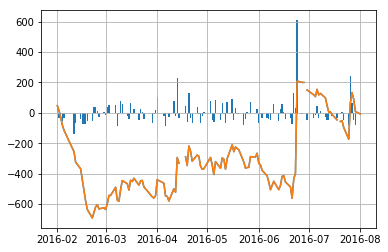

In [114]:
rng=F1.Date.between('2016-02-01','2016-08-01')
dr=F1[rng]
plt.plot(dr.Date,dr.Diff.cumsum())
plt.bar(dr.Date,dr.Diff)
plt.grid()
plt.show()

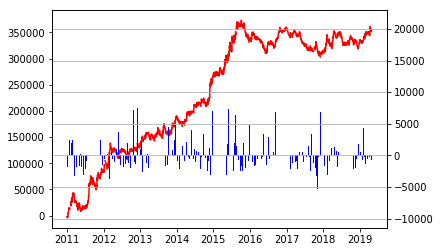

In [163]:
plt.plot(F1.Date,F1.Diff.cumsum()*50,color='r')
plt.twinx()
plt.bar(F1.Date,F1.Diff*50,color='b')
plt.grid()
plt.show()

In [165]:
# F1[F1.Open_Diff>=0].groupby([abs(round(F1.Open_Diff/50,0))])['Diff'].agg(Calc)
Calc=['count','sum','mean','max','min']
idx=4

print(cols[idx],F[idx].Diff.sum())
F1[F1.Trend==idx].groupby(F1.W1//50)['Diff'].agg(Calc)
F1[F1.Trend==idx].groupby(F1.OpenH//50)['Diff'].agg(Calc)
# F[index][F[index].State>0].groupby(['State',F[index].W1//100])['Diff'].agg(Calc)
# F[index][F[index].State>0].groupby(F[index].H1_idx)['Diff'].agg(Calc)

逆势作空 11464.0


count     sum        mean    max    min
OpenH                                         
-19.0      1    43.5   43.500000   43.5   43.5
-17.0      1     8.5    8.500000    8.5    8.5
-11.0      3  -130.5  -43.500000  -38.5  -47.5
-9.0       1    64.0   64.000000   64.0   64.0
-8.0       3   116.5   38.833333  117.0  -31.5
-7.0       4   214.0   53.500000  152.0  -14.0
-6.0       7   -60.5   -8.642857   79.0  -79.0
-5.0      10   -45.0   -4.500000  124.0 -104.0
-4.0      12    20.5    1.708333  116.5  -60.0
-3.0      21   228.5   10.880952  374.5  -79.5
-2.0      36   927.0   25.750000  295.5 -222.0
-1.0      57   806.0   14.140351  273.5  -87.5
 0.0      56  1219.5   21.776786  428.0 -120.0
 1.0      36   571.0   15.861111  349.5  -84.0
 2.0      16  -172.5  -10.781250  184.0 -119.0
 3.0       6    74.5   12.416667  234.0  -72.5
 4.0       4   -74.5  -18.625000   48.0  -80.0
 5.0       4   167.0   41.750000  239.5  -64.5
 6.0       2    73.5   36.750000  116.5  -43.0
 7.0       1   -27.0  -27.000000  -27.0  -27.0
 8.0       1   -42.0  -42.000000  -42.0  -42.0
 9.0       1   215.5  215.500000  215.5  215.5
 12.0      1   -43.5  -43.500000  -43.5  -43.5

In [68]:
# F1=pd.DataFrame(res)
Calc=['count','sum','mean','max','min']
cols=['Null','顺势作多','顺势作空','逆势作多','逆势作空']
#顺势作多
idx=4
print(cols[idx])
# print(F1[F1.Trend==idx].Diff.agg(Calc))
F1[F1.Trend==4].Diff.agg(Calc)
#计算区间的相关性
F1[F1.Trend==idx].groupby([F1.W1//50])['Diff'].agg(Calc)
#开盘相关性
# F1[F1.Trend==idx].groupby(F1.OpenH//50)['Diff'].agg(Calc)

#高点位置相位
# F1[F1.Trend==idx].groupby(F1.L1_idx)['Diff'].agg(Calc)
# F1.groupby('Trend').Diff.agg(Calc)

逆势作空


count    sum        mean    max    min
W1                                          
0.0       2   60.0   30.000000   46.0   14.0
1.0      96 -453.5   -4.723958  282.0  -50.5
2.0     101  873.5    8.648515  349.5  -73.0
3.0      39  371.0    9.512821  240.0  -95.5
4.0      30  558.0   18.600000  249.5 -119.0
5.0      10  725.0   72.500000  383.0  -97.0
6.0       2  103.0   51.500000  141.0  -38.0
7.0       2 -148.5  -74.250000  -44.5 -104.0
8.0       1  -15.0  -15.000000  -15.0  -15.0
9.0       1   51.0   51.000000   51.0   51.0
14.0      1  426.0  426.000000  426.0  426.0

22673.0
7


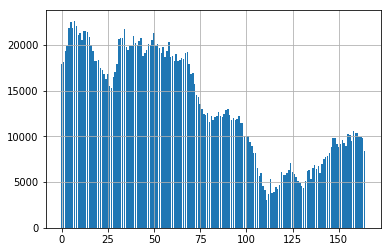

In [89]:
FF=pd.DataFrame(res)
T1=FF.T
T1.head()
print(T1.ALL_Profit.max())
print(T1.ALL_Profit.idxmax())
plt.bar(T1.index,T1.ALL_Profit)
plt.grid(True)
T1
T1.sort_values('ALL_Profit',ascending=False).to_excel("pkl/Begin.xls")

In [16]:
Data={}
DD={}
dl=newDF.datetime.dt.date.unique()

dt1=dt.datetime.now()
cols=['不止损','固定止损-收盘价','固定止损-高低价','移动止损-收盘价','移动止损-高低价']
F={}
for i in range(5):
    Data[i]=[]
    for dd in dl:
        pre=GetPreClose(str(dd))
        Data[i].append(CalcHL(dd,PreClose=pre,Stop_Type=i,Begin=7))

    F[i]=pd.DataFrame(Data[i])
    DD[cols[i]]=GetROI(F[i])

print(dt.datetime.now()-dt1)
pd.DataFrame(DD)

0:02:54.205964


不止损      固定止损-收盘价      固定止损-高低价      移动止损-收盘价  \
ALL_Profit  10307.000000  19648.000000  14355.500000  22673.000000   
All_CNT      1868.000000   1868.000000   1868.000000   1868.000000   
All_Mean        5.517666     10.518201      7.684957     12.137580   
Lose       -89571.000000 -69243.000000 -72405.500000 -47293.000000   
Lose_CNT      954.000000   1117.000000   1144.000000   1059.000000   
Lose_Mean     -93.889937    -61.990152    -63.291521    -44.658168   
ROI             7.100240     26.887591     23.502173     34.231241   
Win         99878.000000  88891.000000  86761.000000  69966.000000   
Win%           48.792271     40.107239     38.659517     43.064516   
Win/Lose        1.170272      1.917050      1.901270      1.955931   
Win_CNT       909.000000    748.000000    721.000000    801.000000   
Win_Mean      109.876788    118.838235    120.334258     87.348315   

                移动止损-高低价  
ALL_Profit  11464.000000  
All_CNT      1868.000000  
All_Mean        6.137045  
Lose       -50286.000000  
Lose_CNT     1102.000000  
Lose_Mean     -45.631579  
ROI            22.754276  
Win         61750.000000  
Win%           40.752688  
Win/Lose        1.785263  
Win_CNT       758.000000  
Win_Mean       81.464380

In [69]:
# F1=F[3]
cols=['Null','顺势作多','顺势作空','逆势作多','逆势作空']
#顺势作多
idx=1
print(cols[idx])
print(F1[F1.Trend==idx].Diff.agg(Calc))

#计算区间的相关性
# F1[cont3].groupby([F1.W1//50])['Diff'].agg(Calc)
#开盘相关性
F1[F1.Trend==idx].groupby(F1.OpenH//50)['Diff'].agg(Calc)

#高点位置相位
# F1[F1.Trend==idx].groupby(F1.H1_idx)['Diff'].agg(Calc)
F1.groupby('Trend').Diff.agg(Calc)

顺势作多
count     658.000000
sum      8113.500000
mean       12.330547
max       554.000000
min      -172.500000
Name: Diff, dtype: float64


count     sum       mean    max    min
Trend                                        
0          0     NaN        NaN    NaN    NaN
1        658  8113.5  12.330547  554.0 -172.5
2        697  6130.5   8.795552  735.0 -196.0
3        243  1119.0   4.604938  655.0 -187.0
4        285  2550.5   8.949123  426.0 -119.0

In [165]:
cont={}
ROI={}
print('优化结果')
ROI['OLD']=(GetROI(F1))


#早盘区间
cont['W1']=(F1.W1<300) & (F1.Trend==1) |  (F1.Trend==2) | (F1.W1<450) & (F1.Trend==3) | (F1.W1>100) & (F1.Trend==4)

cont['W1']=(F1.W1<350) & (F1.Trend==1) |  (F1.Trend==2) | (F1.W1<450) & (F1.Trend==3) | (F1.W1<350) & (F1.W1>50) &(F1.Trend==4) 

#高开区间
cont['OpenH']=(F1.OpenH<350) & (F1.OpenH>=-300) & (F1.Trend==1) | \
             (F1.OpenH<350) & (F1.OpenH>=-300) & (F1.Trend==2) | \
             (F1.OpenH<150) & (F1.OpenH>0) & (F1.Trend==3) |\
             (F1.OpenH<150) &  (F1.Trend==4)
            
#高开区间
cont['OpenH']=(F1.OpenH<350) & (F1.OpenH>=-300) & (F1.Trend==1) | \
             (F1.Trend==2) | \
             (F1.OpenH<350)  & (F1.Trend==3) |\
             (F1.Trend==4)
            

#高开位置
cont['Idx']=(F1.H1_idx<59) & (F1.L1_idx<24) & (F1.Trend==1) | \
            (F1.H1_idx<24) & (F1.L1_idx<57) & (F1.Trend==2) | \
            (F1.H1_idx>6) & (F1.H1_idx<27) & (F1.L1_idx<53) & (F1.Trend==3) |\
            (F1.H1_idx>20) & (F1.H1_idx<46) & (F1.L1_idx<24) & (F1.Trend==4)

ROI['W1']=GetROI(F1[cont['W1']])
ROI['OpenH']=GetROI(F1[cont['OpenH']])
#ROI['Idx']=GetROI(F1[cont['Idx']])
ROI['New']=GetROI(F1[cont['W1']&cont['OpenH']])
print(Get_Drawdown(F1[cont['W1']&cont['OpenH']]))
pd.DataFrame(ROI)


优化结果
{'Dn_Day': 16, 'Dn_Lose': -521.5, 'Day_Lose': -521.5, 'Day_Begin': datetime.date(2015, 11, 26), 'Lose_Day': 16, 'Lose_Begin': datetime.date(2015, 11, 26)}


New           OLD         OpenH            W1
ALL_Profit   7087.500000   7041.500000   7212.500000   6916.500000
All_CNT      1847.000000   1892.000000   1887.000000   1852.000000
All_Mean        3.837304      3.721723      3.822205      3.734611
Lose       -33715.000000 -34609.000000 -34388.000000 -33936.000000
Lose_CNT     1081.000000   1105.000000   1101.000000   1085.000000
Lose_Mean     -31.188714    -31.320362    -31.233424    -31.277419
ROI            21.177675     20.622506     20.922390     20.869993
Win         40802.500000  41650.500000  41600.500000  40852.500000
Win%           41.186072     41.317047     41.373802     41.128595
Win/Lose        1.728198      1.709283      1.714186      1.723132
Win_CNT       757.000000    778.000000    777.000000    758.000000
Win_Mean       53.900264     53.535347     53.539897     53.895119

In [167]:
Calc=['count','sum','mean','max','min']
F2=F1[cont['W1']&cont['OpenH']].copy()
print(F2.Diff.agg(Calc))
F2.Date=pd.to_datetime(F2.Date)
F2.groupby(F2.Date.apply(lambda x:x.year))['Diff'].agg(Calc)
# F2.groupby('Trend')['Diff'].agg(Calc)

count    1847.000000
sum      7087.500000
mean        3.837304
max       427.500000
min      -168.500000
Name: Diff, dtype: float64


count     sum      mean    max    min
Date                                       
2011    227  1607.5  7.081498  299.5 -115.0
2012    219   848.0  3.872146  292.0  -80.0
2013    223  1176.0  5.273543  243.0  -76.5
2014    219  1634.5  7.463470  228.0  -80.0
2015    232  1734.5  7.476293  427.5 -168.5
2016    211   399.5  1.893365  194.5  -75.0
2017    210 -1177.5 -5.607143  173.0 -106.5
2018    232   426.5  1.838362  215.0 -118.0
2019     74   438.5  5.925676  163.0  -51.5

{'Dn_Day': 16, 'Dn_Lose': -521.5, 'Day_Lose': -521.5, 'Day_Begin': Timestamp('2015-11-26 00:00:00'), 'Lose_Day': 16, 'Lose_Begin': Timestamp('2015-11-26 00:00:00')}


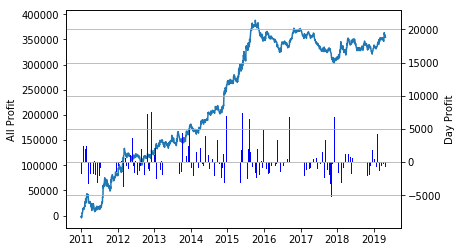

In [169]:
print(Get_Drawdown(F2))
plt.plot(F2.Date,F2.Diff.cumsum()*50)
plt.ylabel("All Profit")
plt.twinx()
plt.bar(F2.Date,F2.Diff*50,color='b')
plt.ylabel("Day Profit")
plt.grid()
plt.show()

In [46]:
Calc=['sum','count','mean','max','min','std']
F1['Open_Diff']=F1.Open-F1.preOpen
res=F1['Diff'].agg(Calc)
print(res)
# F1[F1.Open_Diff>=0].groupby([abs(round(F1.Open_Diff/50,0))])['Diff'].agg(Calc)
F1.groupby('State')['Diff'].agg(Calc)

sum      8875.500000
count    1883.000000
mean        4.713489
max       932.000000
min      -222.000000
std       117.435355
Name: Diff, dtype: float64


sum  count        mean    max    min         std
State                                                      
0          0.0      0         NaN    NaN    NaN         NaN
3     -32110.0    431  -74.501160  -42.0 -222.0   33.037144
4     -36828.5    513  -71.790448  -42.0 -222.0   32.175384
9      41667.0    363  114.785124  606.0    1.0  106.537717
10     43827.0    343  127.775510  932.0    1.0  121.149510
11     -3740.0    107  -34.953271    0.0 -163.0   31.563767
12     -3940.0    126  -31.269841    0.0 -120.0   26.886848

In [30]:
Calc=['sum','count','mean','max','min','std']
F1['Open_Diff']=F1.Open-F1.preOpen
res=F1['Diff'].agg(Calc)
print(res)
F1[F1.Open_Diff>=0].groupby([abs(round(F1.Open_Diff/50,0))])['Diff'].agg(Calc)

sum      8925.000000
count    1842.000000
mean        4.845277
max       933.000000
min      -844.000000
std       147.281557
Name: Diff, dtype: float64


sum  count        mean    max    min         std
Open_Diff                                                     
0.0       -1176.0    165   -7.127273  317.0 -489.0  126.270189
1.0        -493.0    351   -1.404558  468.0 -844.0  151.234922
2.0        2580.0    205   12.585366  712.0 -638.0  151.882400
3.0        -881.0    112   -7.866071  519.0 -529.0  166.141072
4.0        -899.0     53  -16.962264  302.0 -431.0  134.477330
5.0        1163.0     40   29.075000  418.0 -357.0  162.641873
6.0         418.0     20   20.900000  392.0 -310.0  172.536464
7.0        1220.0     15   81.333333  933.0 -334.0  300.317134
8.0          28.0      6    4.666667  192.0 -100.0  100.760442
9.0         199.0      5   39.800000  251.0 -265.0  216.360116
10.0         -1.0      3   -0.333333   28.0  -18.0   24.785749
11.0         36.0      4    9.000000  169.0 -192.0  164.440465
12.0       -345.0      1 -345.000000 -345.0 -345.0         NaN
13.0        -75.0      2  -37.500000  285.0 -360.0  456.083874
14.0         10.0      1   10.000000   10.0   10.0         NaN
17.0        394.0      1  394.000000  394.0  394.0         NaN
18.0        -92.0      1  -92.000000  -92.0  -92.0         NaN

In [14]:
Calc=['count','sum','mean','std','max','min']
print('开盘区间相关')
F1['Diff'].groupby(F1.W1//50).agg(Calc)

开盘区间相关


count     sum        mean         std    max    min
W1                                                       
0.0       8   373.0   46.625000   47.647328  129.0  -29.0
1.0     448   274.0    0.611607  113.108888  444.0 -369.0
2.0     625  3747.0    5.995200  131.126584  418.0 -574.0
3.0     409  3025.0    7.396088  166.880607  712.0 -844.0
4.0     217  -593.0   -2.732719  167.897517  933.0 -638.0
5.0      89  1486.0   16.696629  194.571815  555.0 -503.0
6.0      28   809.0   28.892857  139.144300  394.0 -180.0
7.0      11  -177.0  -16.090909  204.143310  347.0 -452.0
8.0      12   120.0   10.000000  199.833567  241.0 -396.0
9.0       6  -618.0 -103.000000  437.035468  532.0 -502.0
10.0      3   273.0   91.000000  147.400814  193.0  -78.0
11.0      2  -159.0  -79.500000  432.042243  226.0 -385.0
13.0      1    -2.0   -2.000000         NaN   -2.0   -2.0
14.0      1   519.0  519.000000         NaN  519.0  519.0
15.0      0     NaN         NaN         NaN    NaN    NaN
23.0      0     NaN         NaN         NaN    NaN    NaN
25.0      0     NaN         NaN         NaN    NaN    NaN

In [51]:
Data=[]
dl=newDF.datetime.dt.date.unique()
#固定止损
for dd in dl:
    Data.append(Calc(dd,3))
    
print(len(Data))

Data1=[]
#移动止损
for dd in dl:
    Data1.append(Calc(dd,4))
    
print(len(Data1))

F1=pd.DataFrame(Data)
F2=pd.DataFrame(Data1)


DD={}
DD['FixStop']=GetROI(F1)
DD['F_Pre0']=GetROI(F1[F1.PreState==0])
DD['F_Pre1']=GetROI(F1[F1.PreState==1])

DD['MoveStop']=GetROI(F2)
DD['M_Pre0']=GetROI(F2[F2.PreState==0])
DD['M_Pre1']=GetROI(F2[F2.PreState==1])
D1=pd.DataFrame(DD)
col1=['FixStop','MoveStop','F_Pre0','M_Pre0','F_Pre1','M_Pre1']
D1[col1]

2027
2027


FixStop      MoveStop        F_Pre0        M_Pre0  \
ALL_Profit   9653.000000   9422.500000   2633.000000   2131.500000   
All_CNT      1842.000000   1842.000000    940.000000    940.000000   
All_Mean        5.240499      5.115364      2.801064      2.267553   
Lose       -55236.000000 -51986.500000 -30253.000000 -28279.000000   
Lose_CNT     1120.000000   1121.000000    590.000000    591.000000   
Lose_Mean     -49.317857    -46.375112    -51.276271    -47.849408   
ROI            21.780159     22.162404     18.593507     17.972835   
Win         64889.000000  61409.000000  32886.000000  30410.500000   
Win%           38.897981     38.910082     36.898396     36.791444   
Win/Lose        1.845344      1.854594      1.858983      1.847517   
Win_CNT       713.000000    714.000000    345.000000    344.000000   
Win_Mean       91.008415     86.007003     95.321739     88.402616   

                  F_Pre1        M_Pre1  
ALL_Profit   7020.000000   7291.000000  
All_CNT       902.000000    902.000000  
All_Mean        7.782705      8.083149  
Lose       -24983.000000 -23707.500000  
Lose_CNT      530.000000    530.000000  
Lose_Mean     -47.137736    -44.731132  
ROI            25.604150     26.999566  
Win         32003.000000  30998.500000  
Win%           40.979955     41.111111  
Win/Lose        1.844906      1.872962  
Win_CNT       368.000000    370.000000  
Win_Mean       86.964674     83.779730

In [37]:
# F1[['Stop','Diff_S']][F1.State>=7].agg(['mean'])
F2['W2']=F2.W1//50
col1=['PreState','W1','W2','State','Close','Diff_S']
col2=['PreState','Close','State','DiffH','DiffL','W1','Diff_S','Diff_L','Diff_H','Stop']
dd={
    'Close':['count'],
    'Diff_S':['sum','mean','max','min'],

}
a1=F2[col1].groupby(['PreState','W2','State']).agg(dd) 
a1
# a1.to_excel("HL_STA.xls")

In [6]:
col2=['PreState','H1i','L1i','DiffH','DiffL','Close','State','Diff','Diff_S','Diff_L','Diff_H','Stop']
F1[col2]

PreState       H1i       L1i  DiffH  DiffL    Close  State   Diff  \
Date                                                                            
2014-01-02         0  09:29:00  10:14:00  186.0    0.0  23334.0      6  -45.0   
2014-01-03         0  09:15:00  10:00:00  186.0   49.0  22790.0      4  105.0   
2014-01-06         0  09:15:00  09:45:00  148.0   62.0  22679.0      0    NaN   
2014-01-07         1  09:39:00  09:17:00   95.0   40.0  22612.0      7 -151.0   
2014-01-08         1  09:49:00  09:15:00   35.0  145.0  22944.0      3   18.0   
2014-01-09         1  09:49:00  09:19:00   30.0   63.0  22788.0      7 -205.0   
2014-01-10         1  10:12:00  09:16:00   20.0  238.0  22863.0      0    NaN   
2014-01-13         0  09:16:00  10:14:00  277.0    0.0  22827.0      4   16.0   
2014-01-14         1  10:00:00  09:18:00   39.0  147.0  22769.0      5   -8.0   
2014-01-15         0  09:18:00  10:14:00  191.0    0.0  22910.0      8  -85.0   
2014-01-16         0  09:15:00  09:46:00   85.0   67.0  22973.0      8  -56.0   
2014-01-17         1  09:35:00  09:26:00   50.0   44.0  23166.0      3  204.0   
2014-01-20         1  10:02:00  09:35:00   37.0   90.0  22869.0      4  103.0   
2014-01-21         1  10:03:00  09:31:00   29.0   83.0  23047.0      7  -80.0   
2014-01-22         1  09:52:00  09:32:00   27.0  143.0  23055.0      5  -45.0   
2014-01-23         0  09:17:00  10:05:00  361.0   53.0  22721.0      6   -7.0   
2014-01-24         1  09:53:00  09:21:00    2.0  113.0  22424.0      7 -193.0   
2014-01-27         0  09:20:00  09:48:00   86.0   48.0  21925.0      7  -91.0   
2014-01-28         1  09:46:00  09:29:00   59.0   22.0  22011.0      8 -100.0   
2014-01-29         1  09:52:00  09:20:00   40.0   94.0  22182.0      0    NaN   
2014-01-30         0  09:34:00  09:47:00   55.0   50.0  22012.0      3  176.0   
2014-02-04         1  09:50:00  09:33:00   13.0   82.0  21447.0      4   43.0   
2014-02-05         0  09:18:00  10:12:00  120.0    5.0  21197.0      4  198.0   
2014-02-06         1  10:11:00  09:24:00   15.0  120.0  21332.0      7  -40.0   
2014-02-07         1  09:55:00  09:24:00   14.0  195.0  21527.0      5  -67.0   
2014-02-10         1  09:50:00  09:36:00   19.0   93.0  21517.0      6  -10.0   
2014-02-11         1  10:14:00  09:16:00    0.0  251.0  21902.0      3  131.0   
2014-02-12         1  10:05:00  09:15:00   52.0   93.0  22258.0      3  151.0   
2014-02-13         0  09:19:00  09:59:00   96.0   53.0  22160.0      6  -53.0   
2014-02-14         0  09:25:00  10:05:00  166.0   14.0  22324.0      0    NaN   
...              ...       ...       ...    ...    ...      ...    ...    ...   
2019-02-18         1  09:40:00  09:17:00   45.0  145.0  28334.0      5  -23.0   
2019-02-19         1  09:56:00  09:34:00   72.0   83.0  28155.0      4  121.0   
2019-02-20         1  09:54:00  09:15:00   40.0  172.0  28510.0      7  -61.0   
2019-02-21         1  10:10:00  09:32:00   39.0  157.0  28655.0      3   53.0   
2019-02-22         0  09:15:00  09:59:00   94.0   46.0  28806.0      3  223.0   
2019-02-25         0  09:46:00  09:56:00   70.0  123.0  28890.0      8  -86.0   
2019-02-26         0  09:19:00  09:49:00   57.0  105.0  28727.0      4   74.0   
2019-02-27         1  09:46:00  09:22:00   62.0   47.0  28864.0      7  -65.0   
2019-02-28         1  10:14:00  09:27:00    0.0  224.0  28666.0      7 -238.0   
2019-03-01         0  09:15:00  09:36:00   64.0   24.0  28730.0      7  -43.0   
2019-03-04         1  09:37:00  09:31:00    7.0   80.0  28885.0      3   58.0   
2019-03-05         0  09:20:00  09:24:00   43.0   83.0  28890.0      7   60.0   
2019-03-06         1  09:51:00  09:27:00   91.0   98.0  29029.0      7  -43.0   
2019-03-07         1  10:07:00  09:40:00   30.0   85.0  28723.0      8   98.0   
2019-03-08         0  09:15:00  09:30:00   75.0   71.0  28236.0      7 -231.0   
2019-03-11         1  10:01:00  09:15:00   53.0  132.0  28485.0      3  135.0   
2019-03-12         1  09:45:00  09:16:00   

In [8]:
col2=['PreState','Close','State','DiffH','DiffL','W1','Diff_S','Diff_L','Diff_H','Stop']
dd={
    'Close':['count'],
    'Diff_S':['sum','mean','max','min'],
    'W1':['sum','mean','max','min'],
    'DiffH':['sum','mean','max','min'],
    'DiffL':['sum','mean','max','min'],

}
F1[col2].groupby(['PreState','State']).agg(dd)
# F1[col2].groupby(F1.index.year).agg(dd)

Close   Diff_S                                 W1              \
               count      sum        mean    max    min      sum        mean   
PreState State                                                                 
0        0        51      NaN         NaN    NaN    NaN   9640.0  189.019608   
         3        55   6947.0  126.309091  378.0    2.0   8053.0  146.418182   
         4       161  22472.0  139.577640  712.0    2.0  31663.0  196.664596   
         5        20   -628.0  -31.400000    0.0 -129.0   3490.0  174.500000   
         6        75  -2658.0  -35.440000    0.0 -119.0  15802.0  210.693333   
         7        76  -6174.0  -81.236842  -43.0 -245.0  11056.0  145.473684   
         8       201 -17429.0  -86.711443  -42.0 -228.0  31334.0  155.890547   
1        0        47      NaN         NaN    NaN    NaN   9711.0  206.617021   
         3       192  21316.0  111.020833  607.0    1.0  32779.0  170.723958   
         4        63   7818.0  124.095238  933.0   11.0  10103.0  160.365079   
         5        58  -2139.0  -36.879310   -2.0 -162.0  11734.0  202.310345   
         6        17   -450.0  -26.470588   -2.0  -96.0   2946.0  173.294118   
         7       186 -16594.0  -89.215054  -42.0 -248.0  30901.0  166.134409   
         8        89  -6679.0  -75.044944  -42.0 -192.0  12034.0  135.213483   

                                DiffH                             DiffL  \
                   max   min      sum        mean    max   min      sum   
PreState State                                                            
0        0       408.0  92.0   5823.0  114.176471  300.0  15.0   3817.0   
         3       359.0  42.0   4433.0   80.600000  255.0   1.0   3620.0   
         4       732.0  56.0  25529.0  158.565217  560.0  21.0   6134.0   
         5       462.0  61.0   2155.0  107.750000  411.0  15.0   1335.0   
         6       663.0  71.0  13103.0  174.706667  594.0  27.0   2699.0   
         7       474.0  45.0   5905.0   77.697368  393.0   1.0   5151.0   
         8       566.0  51.0  24837.0  123.567164  397.0   6.0   6497.0   
1        0      1191.0  55.0   2542.0   54.085106  542.0   0.0   7169.0   
         3       417.0  57.0   6011.0   31.307292  152.0   0.0  26768.0   
         4       745.0  57.0   4644.0   73.714286  474.0   0.0   5459.0   
         5       435.0  67.0   2218.0   38.241379  127.0   0.0   9516.0   
         6       419.0  70.0    838.0   49.294118  140.0  14.0   2108.0   
         7      1254.0  58.0   5713.0   30.715054  161.0   0.0  25188.0   
         8       381.0  65.0   5936.0   66.696629  184.0   4.0   6098.0   

                                          
                      mean     max   min  
PreState State                            
0        0       74.843137   251.0   1.0  
         3       65.818182   188.0   0.0  
         4       38.099379   389.0   0.0  
         5       66.750000   212.0  27.0  
         6       35.986667   108.0   0.0  
         7       67.776316   312.0   0.0  
         8       32.323383   169.0   0.0  
1        0      152.531915   649.0  14.0  
         3      139.416667   414.0  11.0  
         4       86.650794   271.0   1.0  
         5      164.068966   388.0  13.0  
         6      124.000000   291.0  15.0  
         7      135.419355  1254.0  14.0  
         8       68.516854   297.0   3.0

In [7]:
a1=F1[F1.PreState==0].sort_values('Diff_S',ascending=False).head(200)
a1[col2].agg(dd)
a1[col2]

TypeError: ("'datetime.date' object is not callable", 'occurred at index PreState')

__init__


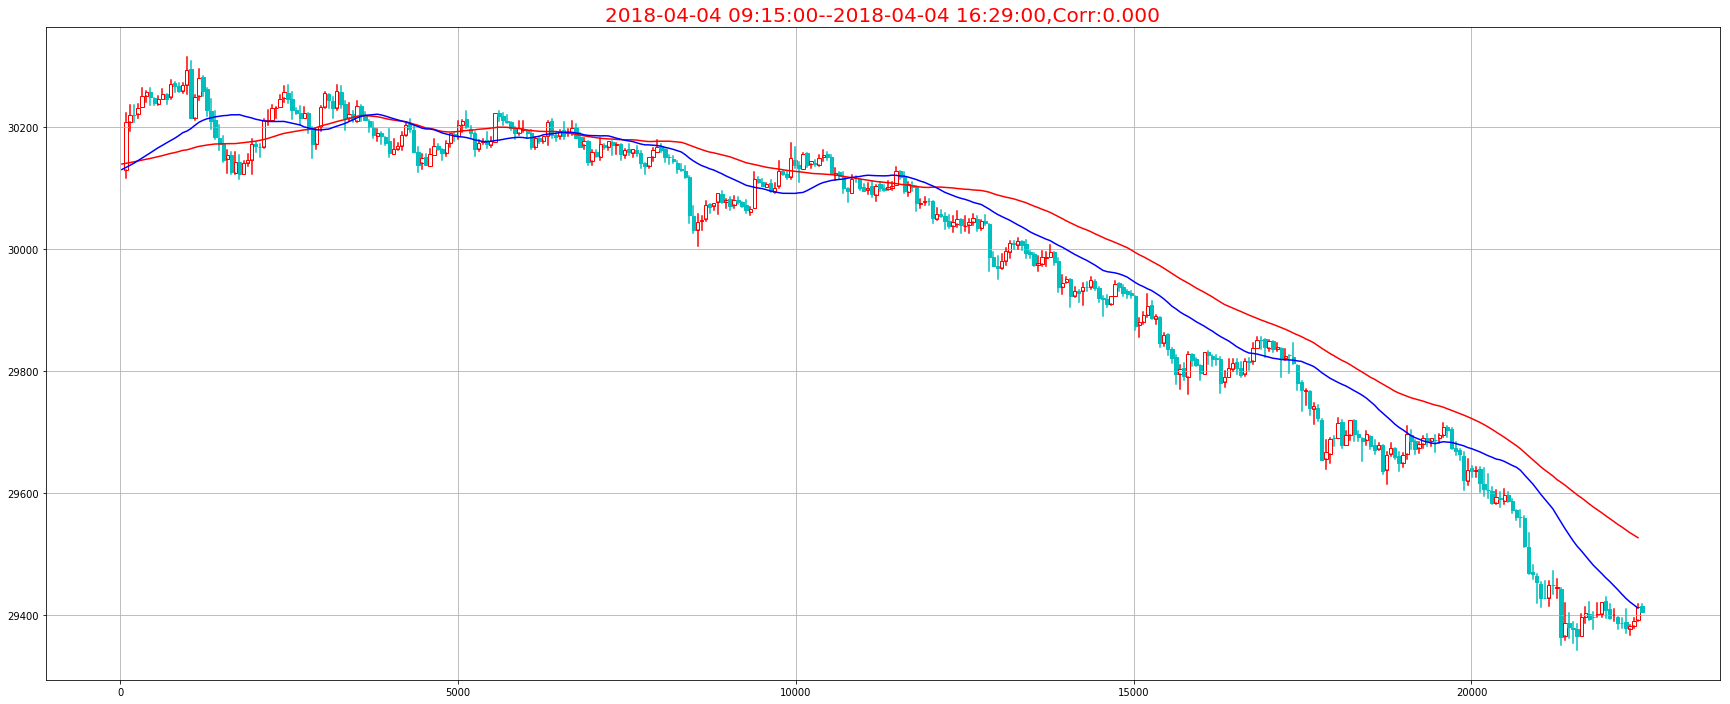

In [10]:
date='2017-12-06'
date=str(a1.iloc[0].name.date())
dd=newDF[date]
sa1=CORR()
sa1.DrawKK(dd)
# plt.show()

In [33]:
a1=F1[(F1.PreState==0) & (pd.notnull(F1.Diff_S))].sort_values('Diff_S',ascending=False).tail(20)
sa1=CORR()
for i,row in a1.iterrows():
    dd=str(i.date())
    diff=row['Diff_S']
    res="%s_%.2f_"%(dd,diff)
    print(res)
    df=newDF[dd]
    sa1.DrawKK(df,isSave=True,preF=res)


__init__
2018-07-06_-146.00_
2018-04-18_-148.00_
2018-10-29_-150.00_
2014-11-07_-150.00_
2015-08-04_-152.00_
2018-07-16_-153.00_
2017-04-07_-153.00_
2019-01-17_-159.00_
2018-09-10_-160.00_
2018-04-23_-163.00_
2015-10-08_-171.00_
2018-06-12_-172.00_
2018-10-24_-179.00_
2017-11-06_-193.00_
2018-02-09_-220.00_
2015-09-02_-221.00_
2015-04-10_-222.00_
2015-08-26_-225.00_
2018-07-03_-228.00_
2018-02-20_-245.00_


In [31]:
F1[pd.notnull(F1.Diff_S)]

Close   Close1   Diff  DiffH  DiffL  Diff_S       H1i        Hi  \
Date                                                                            
2014-01-02  23334.0  23299.0  -45.0  186.0    0.0   -45.0  09:29:00  09:30:00   
2014-01-03  22790.0  22951.0  105.0  186.0   49.0   105.0  09:15:00  09:15:00   
2014-01-07  22612.0  22649.0 -151.0   95.0   40.0   -73.0  09:39:00  10:39:00   
2014-01-08  22944.0  22874.0   18.0   35.0  145.0    18.0  09:49:00  13:07:00   
2014-01-09  22788.0  22949.0 -205.0   30.0   63.0   -53.0  09:49:00  10:59:00   
2014-01-13  22827.0  22867.0   16.0  277.0    0.0    16.0  09:16:00  09:16:00   
2014-01-14  22769.0  22730.0   -8.0   39.0  147.0    -8.0  10:00:00  11:16:00   
2014-01-15  22910.0  22827.0  -85.0  191.0    0.0   -98.0  09:18:00  09:18:00   
2014-01-16  22973.0  22988.0  -56.0   85.0   67.0   -78.0  09:15:00  09:15:00   
2014-01-17  23166.0  22893.0  204.0   50.0   44.0   204.0  09:35:00  13:12:00   
2014-01-20  22869.0  23070.0  103.0   37.0   90.0   103.0  10:02:00  10:02:00   
2014-01-21  23047.0  23072.0  -80.0   29.0   83.0   -80.0  10:03:00  09:15:00   
2014-01-22  23055.0  23068.0  -45.0   27.0  143.0   -45.0  09:52:00  10:56:00   
2014-01-23  22721.0  22779.0   -7.0  361.0   53.0    -7.0  09:17:00  09:17:00   
2014-01-24  22424.0  22598.0 -193.0    2.0  113.0   -66.0  09:53:00  10:45:00   
2014-01-27  21925.0  21925.0  -91.0   86.0   48.0   -69.0  09:20:00  09:15:00   
2014-01-28  22011.0  21939.0 -100.0   59.0   22.0   -42.0  09:46:00  16:14:00   
2014-01-30  22012.0  21772.0  176.0   55.0   50.0   176.0  09:34:00  11:59:00   
2014-02-04  21447.0  21580.0   43.0   13.0   82.0    43.0  09:50:00  09:50:00   
2014-02-05  21197.0  21414.0  198.0  120.0    5.0   198.0  09:18:00  09:16:00   
2014-02-06  21332.0  21347.0  -40.0   15.0  120.0   -72.0  10:11:00  10:47:00   
2014-02-07  21527.0  21578.0  -67.0   14.0  195.0   -67.0  09:55:00  14:56:00   
2014-02-10  21517.0  21604.0  -10.0   19.0   93.0   -10.0  09:50:00  09:15:00   
2014-02-11  21902.0  21764.0  131.0    0.0  251.0   131.0  10:14:00  15:04:00   
2014-02-12  22258.0  22053.0  151.0   52.0   93.0   151.0  10:05:00  15:35:00   
2014-02-13  22160.0  22162.0  -53.0   96.0   53.0   -53.0  09:19:00  09:19:00   
2014-02-17  22529.0  22535.0  -64.0   27.0   67.0   -52.0  09:49:00  09:49:00   
2014-02-18  22581.0  22467.0   27.0   72.0   28.0   -54.0  09:15:00  13:00:00   
2014-02-19  22636.0  22577.0 -100.0   69.0   35.0   -55.0  09:41:00  13:15:00   
2014-02-20  22374.0  22401.0  -14.0  336.0    5.0   -14.0  09:44:00  09:44:00   
...             ...      ...    ...    ...    ...     ...       ...       ...   
2019-02-18  28334.0  28293.0  -23.0   45.0  145.0   -23.0  09:40:00  11:15:00   
2019-02-19  28155.0  28365.0  121.0   72.0   83.0   121.0  09:56:00  09:56:00   
2019-02-20  28510.0  28503.0  -61.0   40.0  172.0  -108.0  09:54:00  10:30:00   
2019-02-21  28655.0  28545.0   53.0   39.0  157.0    53.0  10:10:00  13:45:00   
2019-02-22  28806.0  28468.0  223.0   94.0   46.0   223.0  09:15:00  16:20:00   
2019-02-25  28890.0  28936.0  -86.0   70.0  123.0  -106.0  09:46:00  09:46:00   
2019-02-26  28727.0  28919.0   74.0   57.0  105.0    74.0  09:19:00  09:15:00   
2019-02-27  28864.0  28864.0  -65.0   62.0   47.0   -60.0  09:46:00  13:29:00   
2019-02-28  28666.0  28884.0 -238.0    0.0  224.0  -119.0  10:14:00  10:45:00   
2019-03-01  28730.0  28696.0  -43.0   64.0   24.0   -66.0  09:15:00  10:57:00   
2019-03-04  28885.0  28814.0   58.0    7.0   80.0    58.0  09:37:00  13:07:00   
2019-03-05  28890.0  28769.0   60.0   43.0   83.0   -66.0  09:20:00  14:50:00   
2019-03-06  29029.0  28974.0  -43.0   91.0   98.0  -108.0  09:51:00  10:40:00   
2019-03-07  28723.0  28963.0   98.0   30.0   85.0   -75.0  10:07:00  09:20:00   
2019-03-08  28236.0  28383.0 -231.0   75.0   71.0   -91.0  09:15:00  10:44:00   
2019-03-11  28485.0  28290.0  135.0   53.0  132.0   135.0  10:01:00  16:01:00   
2019-03-12  28905.0  28833.0   47.0   23.0   

In [31]:
cols=['Diff_S','Diff','Diff_W','Stop']
dd={
    'Diff_S':['count','mean','sum','max','min','std'],
    'Diff':['mean'],
    'Diff_W':['mean']
}
F1[cols].resample('A').agg(dd)

Diff_S                                                    Diff  \
            count       mean     sum    max    min         std       mean   
Date                                                                        
2014-12-31    223   1.807175   403.0  384.0 -156.0  100.528944  -3.582960   
2015-12-31    231   3.872294   894.5  555.0 -222.0  139.308751  -2.606061   
2016-12-31    230  -1.706522  -392.5  374.0 -140.5   95.537469  -4.021739   
2017-12-31    217   3.642857   790.5  567.0 -188.5  104.608808  -0.368664   
2018-12-31    236  17.516949  4134.0  933.0 -222.0  169.120043  16.936441   
2019-12-31     56  15.232143   853.0  374.0 -146.0  117.105429  11.089286   

                Diff_W  
                  mean  
Date                    
2014-12-31  142.340081  
2015-12-31  195.352227  
2016-12-31  157.167347  
2017-12-31  137.500000  
2018-12-31  221.272358  
2019-12-31  184.533333

In [601]:
F1.Diff_S.sum()

7085.0

In [27]:
F1['W1']=F1.Diff_W//50
cols=['W1','Diff_S','Diff','Diff_W','Stop']
F1[cols].groupby('W1').agg(['sum','count','mean'])

Diff_S                      Diff                     Diff_W        \
         sum count        mean     sum count        mean      sum count   
W1                                                                        
0.0     77.0     2   38.500000   221.0     2  110.500000     87.0     2   
1.0    480.0   221    2.171946  -906.0   221   -4.099548  19414.0   234   
2.0   1502.0   370    4.059459  2201.0   370    5.948649  49142.0   396   
3.0   2443.0   277    8.819495  2508.0   277    9.054152  50891.0   297   
4.0    605.0   171    3.538012 -1254.0   171   -7.333333  41653.0   188   
5.0    359.0    65    5.523077    13.0    65    0.200000  21266.0    79   
6.0     51.0    37    1.378378  -185.0    37   -5.000000  13149.0    41   
7.0    118.0    17    6.941176   -55.0    17   -3.235294   6690.0    18   
8.0   -357.0    16  -22.312500  -201.0    16  -12.562500   7104.0    17   
9.0    137.0     7   19.571429  -566.0     7  -80.857143   3276.0     7   
10.0   273.0     3   91.000000   273.0     3   91.000000   2087.0     4   
11.0     4.0     2    2.000000  -159.0     2  -79.500000   1149.0     2   
13.0    -2.0     1   -2.000000    -2.0     1   -2.000000    663.0     1   
14.0   602.0     2  301.000000   602.0     2  301.000000   1477.0     2   
15.0  -248.0     1 -248.000000  -167.0     1 -167.000000    753.0     1   
23.0     NaN     0         NaN     NaN     0         NaN   1191.0     1   
25.0  -242.0     1 -242.000000  -111.0     1 -111.000000   1254.0     1   

                      Stop                    
             mean      sum count        mean  
W1                                            
0.0     43.500000     80.0     2   40.000000  
1.0     82.965812  10158.5   234   43.412393  
2.0    124.095960  24571.0   396   62.047980  
3.0    171.350168  25445.5   297   85.675084  
4.0    221.558511  20826.5   188  110.779255  
5.0    269.189873  10633.0    79  134.594937  
6.0    320.707317   6574.5    41  160.353659  
7.0    371.666667   3345.0    18  185.833333  
8.0    417.882353   3552.0    17  208.941176  
9.0    468.000000   1540.0     7  220.000000  
10.0   521.750000    880.0     4  220.000000  
11.0   574.500000    440.0     2  220.000000  
13.0   663.000000    220.0     1  220.000000  
14.0   738.500000    440.0     2  220.000000  
15.0   753.000000    220.0     1  220.000000  
23.0  1191.000000    220.0     1  220.000000  
25.0  1254.000000    220.0     1  220.000000

In [495]:
F1[(F1['Action']>=0) & (F1['Diff']<0)][cols].resample('Y').agg(dd)

Diff_S                                                    Diff  \
            count       mean      sum   max    min        std        mean   
Date                                                                        
2014-12-31    127 -74.976378  -9522.0  -2.0 -149.0  40.301338  -84.519685   
2015-12-31    114 -90.114035 -10273.0  -1.0 -223.0  39.545819 -133.491228   
2016-12-31    122 -73.508197  -8968.0  -1.0 -128.0  39.977937  -84.877049   
2017-12-31    121 -65.115702  -7879.0  -1.0 -118.0  38.732241  -71.892562   
2018-12-31    106 -93.103774  -9869.0  -2.0 -176.0  35.685646 -142.660377   
2019-12-31     17 -72.352941  -1230.0 -17.0 -122.0  42.293530  -91.882353   

                                                  Diff_W              Win  \
                sum   max    min         std        mean         std  sum   
Date                                                                        
2014-12-31 -10734.0  -2.0 -523.0   84.297833  137.685039   65.653818  0.0   
2015-12-31 -15218.0  -1.0 -843.0  137.184279  193.894737  143.578992  0.0   
2016-12-31 -10355.0  -1.0 -382.0   75.351910  154.368852   77.610833  0.0   
2017-12-31  -8699.0  -1.0 -451.0   72.690646  137.495868   61.992355  0.0   
2018-12-31 -15122.0  -2.0 -637.0  135.196709  229.981132   85.937628  0.0   
2019-12-31  -1562.0 -17.0 -237.0   79.407873  213.588235   60.509358  0.0   

             Lose  Stop  
              sum   sum  
Date                     
2014-12-31  127.0  62.0  
2015-12-31  114.0  78.0  
2016-12-31  122.0  66.0  
2017-12-31  121.0  47.0  
2018-12-31  106.0  85.0  
2019-12-31   17.0   9.0

In [497]:
F1[F1['Action']==0][cols].resample('Y').agg(dd)

Diff_S                                                    Diff  \
            count       mean     sum    max    min         std       mean   
Date                                                                        
2014-12-31    102   1.088235   111.0  369.0 -131.0  106.076481   3.382353   
2015-12-31    120 -13.716667 -1646.0  556.0 -137.0  136.022624 -20.291667   
2016-12-31    110  -2.181818  -240.0  363.0 -128.0  104.820702  -2.318182   
2017-12-31    109  19.155963  2088.0  376.0 -118.0  102.892534  22.724771   
2018-12-31    110  17.818182  1960.0  608.0 -176.0  145.666780  14.481818   
2019-12-31     21  56.952381  1196.0  375.0 -118.0  143.761426  47.666667   

                                                  Diff_W               Win  \
               sum    max    min         std        mean         std   sum   
Date                                                                         
2014-12-31   345.0  369.0 -404.0  121.200272  130.490196   53.672041  45.0   
2015-12-31 -2435.0  556.0 -501.0  174.635534  193.983333  139.348423  45.0   
2016-12-31  -255.0  363.0 -382.0  117.684381  154.018182   53.049913  50.0   
2017-12-31  2477.0  376.0 -293.0  105.069454  131.614679   52.291368  57.0   
2018-12-31  1593.0  608.0 -637.0  187.297915  217.581818   85.998441  53.0   
2019-12-31  1001.0  375.0 -237.0  159.450410  199.619048   47.027095  12.0   

            Lose  Stop  
             sum   sum  
Date                    
2014-12-31  57.0  28.0  
2015-12-31  75.0  58.0  
2016-12-31  60.0  34.0  
2017-12-31  52.0  20.0  
2018-12-31  57.0  45.0  
2019-12-31   9.0   5.0

In [364]:
F1[(F1['Action']>=0) & (F1['Diff']<0)][cols].resample('Y').agg(CalcList)

Diff_S                                    Diff                 \
                 mean      sum   max    min count        mean      sum   max   
Date                                                                           
2014-12-31 -74.976378  -9522.0  -2.0 -149.0   127  -84.519685 -10734.0  -2.0   
2015-12-31 -90.114035 -10273.0  -1.0 -223.0   114 -133.491228 -15218.0  -1.0   
2016-12-31 -73.508197  -8968.0  -1.0 -128.0   122  -84.877049 -10355.0  -1.0   
2017-12-31 -65.115702  -7879.0  -1.0 -118.0   121  -71.892562  -8699.0  -1.0   
2018-12-31 -93.103774  -9869.0  -2.0 -176.0   106 -142.660377 -15122.0  -2.0   
2019-12-31 -72.352941  -1230.0 -17.0 -122.0    17  -91.882353  -1562.0 -17.0   

                         ...      Diff_H                             \
              min count  ...        mean     sum    max   min count   
Date                     ...                                          
2014-12-31 -523.0   127  ...   34.062992  4326.0  264.0 -20.0   127   
2015-12-31 -843.0   114  ...   61.061404  6961.0  507.0 -25.0   114   
2016-12-31 -382.0   122  ...   39.426230  4810.0  489.0 -26.0   122   
2017-12-31 -451.0   121  ...   33.099174  4005.0  141.0 -15.0   121   
2018-12-31 -637.0   106  ...   55.839623  5919.0  323.0 -32.0   106   
2019-12-31 -237.0    17  ...   37.764706   642.0  111.0 -11.0    17   

                Diff_W                                
                  mean      sum     max    min count  
Date                                                  
2014-12-31  137.685039  17486.0   414.0   51.0   127  
2015-12-31  193.894737  22104.0  1254.0   68.0   114  
2016-12-31  154.368852  18833.0   663.0   68.0   122  
2017-12-31  137.495868  16637.0   388.0   58.0   121  
2018-12-31  229.981132  24378.0   488.0   89.0   106  
2019-12-31  213.588235   3631.0   338.0  109.0    17  

[6 rows x 25 columns]

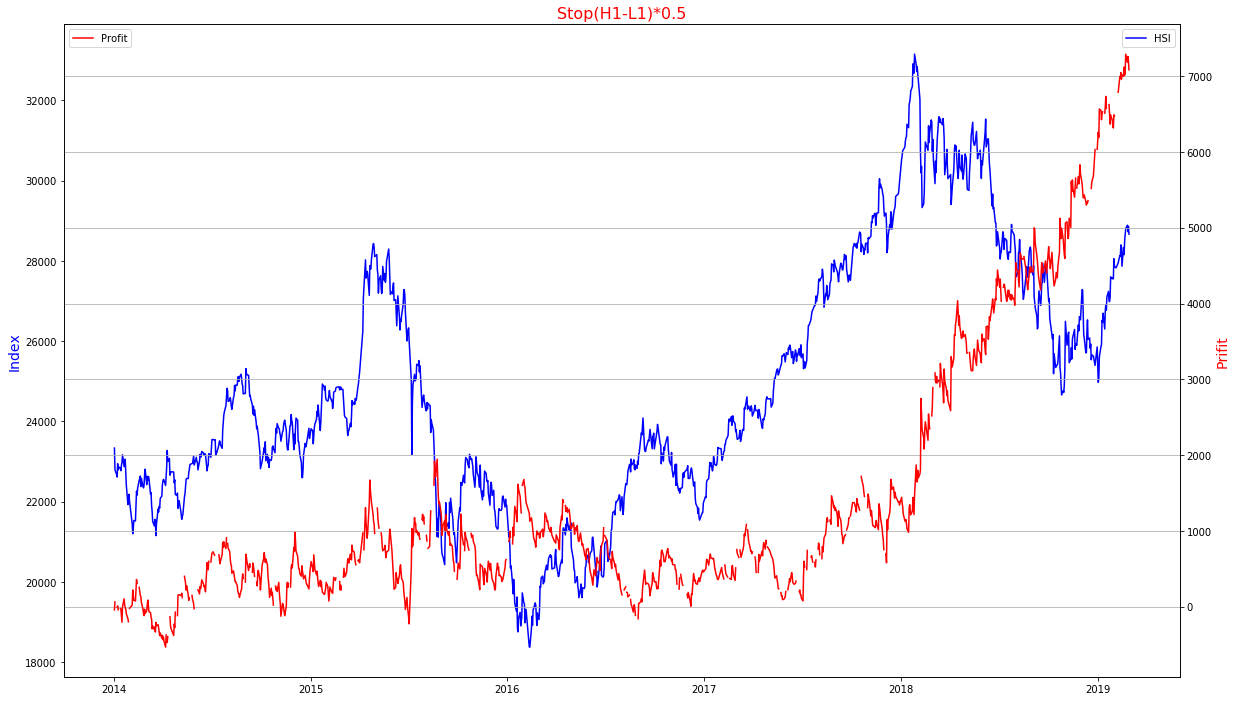

In [611]:
# fig, ax = plt.subplots(）
f1=plt.figure(figsize=(20,12))

ax=f1.add_subplot(111)
# ax.plot(DFtest.index,DFtest['Diff'].cumsum(),C='G')
ax.plot(F1.index,F1['Close'],c='B', label='HSI')
ax.set_ylabel("Index",color='B',size=14)
ax.legend(loc='upper right')
ax1=ax.twinx()

ax1.plot(F1.index,F1['Diff_S'].cumsum(),C='R', label='Profit')
ax1.set_ylabel("Prifit",color='R',size=14)
ax1.legend(loc='upper left')
ax.set_title("Stop(H1-L1)*0.5",size=16,Color='r')
plt.grid(True)
# f1.savefig("HL3.jpg")

plt.show()
plt.close()

In [430]:
col1=['LiM','Close']
a=F1[F1.Close>F1.Open][col1].groupby('LiM')
a.get_group(0).resample('Y').count()
# F1[['LiM']][F1.Close>F1.Open].resample('Y').count()

LiM  Close
Date                  
2014-12-31   94     94
2015-12-31   82     82
2016-12-31  100    100
2017-12-31  107    107
2018-12-31   91     91
2019-12-31   18     18

In [28]:
T1=DFi[DFi['Close']-DFi['Open']>0]
print(T1.shape,492/640)
T1.groupby('LiM').agg('count')

(640, 11) 0.76875


Date  Open  High  Low  Close  Hindex  Lindex  HiH  LiH  HiM
LiM                                                             
0     492   492   492  492    492     492     492  492  492  492
1      76    76    76   76     76      76      76   76   76   76
2      19    19    19   19     19      19      19   19   19   19
3       5     5     5    5      5       5       5    5    5    5
4      29    29    29   29     29      29      29   29   29   29
5      12    12    12   12     12      12      12   12   12   12
6       7     7     7    7      7       7       7    7    7    7

In [31]:
T2=DFi[DFi['Close']-DFi['Open']<0]
print(T2.shape,498/625)
T2.groupby('HiM').agg('count')


(625, 11) 0.7968


Date  Open  High  Low  Close  Hindex  Lindex  HiH  LiH  LiM
HiM                                                             
0     498   498   498  498    498     498     498  498  498  498
1      58    58    58   58     58      58      58   58   58   58
2      21    21    21   21     21      21      21   21   21   21
3       9     9     9    9      9       9       9    9    9    9
4      23    23    23   23     23      23      23   23   23   23
5      12    12    12   12     12      12      12   12   12   12
6       4     4     4    4      4       4       4    4    4    4

In [80]:
np.pi

3.141592653589793

In [ ]:
#  涨的话 71% 最低点发生在 9点左右
#  跌的话 73% 最高点出现在9点左右

In [48]:
df2=df1.head()
# df2.datetime.apply(lambda x:x.time())
time1=dt.time(9,15,0)
time2=dt.time(16,30,0)
tm1=df1[df1['datetime'].dt.time==time1]
tm2=df1[df1['datetime'].dt.time==time1]
# df2.datetime.dt.time
print(tm1.shape,tm2.shape)


(531, 6) (531, 6)


In [346]:
DFtest.columns

Index(['Action', 'Close', 'Diff', 'Diff_S', 'High', 'High1', 'High2', 'Low',
       'Low1', 'Low2', 'Open', 'Price', 'Ref', 'StopPrice', 'Diff_L', 'Diff_H',
       'Diff_W'],
      dtype='object')

In [10]:
date='2015-09-08'

aa=df1[date]
DrawKK(aa)

In [8]:
def DrawKK(aa):
    fig =plt.figure(figsize=(30, 12),facecolor='w')

    ax =fig.add_subplot(111)
#     ax=plt.gca()
    k_width = 50
    k_diff = 10
    kline = k_width + k_diff
    d=0
    rows=len(aa)
    for i in aa.iterrows():
        d=d+1
        x = d * kline
        O = i[1]['open']
        C = i[1]['close']
        L = i[1]['low']
        H = i[1]['high']
        hh = abs(C - O)
        x1 = x + k_width / 2
        if C > O:
            a = False
            y = O
            cc = 'R'
            # 上影线 下影线
            line1 = Line2D((x1, x1), (C, H), color=cc)
            line2 = Line2D((x1, x1), (O, L), color=cc)

            ax.add_line(line1)
            ax.add_line(line2)
        else:
            a = True
            y = C
            cc = 'C'
            # 影线
            line = Line2D((x1, x1), (L, H), color=cc)
            ax.add_line(line)
        hh = abs(C - O)

        # K线实体
        rec = Rectangle((x, y), k_width, hh, fill=a, color=cc)
        ax.add_patch(rec)

    # plt.plot(aa.index*kline + k_width / 2,aa['ma60'],c='r')
    # plt.plot(aa.index*kline + k_width / 2,aa['ma30'],c='b')
    ax.grid()
    ax.autoscale(tight=False)
    ax.autoscale_view()
    # title="%s--%s,Corr:%.3f" %(time1,time2,corr)
    # ax.set_title(title, fontsize=20, color='r')
    # if isSave:
    #     file="res/%s%d_%.7s.jpg"%(preF,self.Amount,time1)
    #     fig.savefig(file)
    #     self.FIG=fig
    #     fig.clear()
    #     plt.close(fig)

In [255]:
-300//50

-6